# LSTM-based Weather Forecasting System with Concurrent Processing

I implemented a threading system for weather forecasting using LSTM neural networks. The implementation follows a producer-consumer pattern with buffer-based communication between threads, showcasing thread safety through mutexes and semaphores.

## System Architecture Overview

The system consists of 5 main components that run concurrently:
1. **Preprocessing**: Loads and prepares data, feeding it into shared buffers (Producer)
2. **Training**: Consumes data from training buffer to train the LSTM model (Consumer and Producer for Inference)
3. **Inference**: Uses the trained model to make predictions (Consumer and Producer for Analysis)
4. **Analysis**: Calculates performance metrics on the model's predictions (Consumer and Producer for Display)
5. **Display**: Visualizes the results (Consumer)

These components are implemented as separate threads that communicate through shared buffers and synchronize using semaphores and thread events.

![Process Flow](Process.jpg)

## Petri Net Representation

The concurrent system can be modeled as a Petri net with:
- **Places**: Buffers, data states (ready/processed)
- **Transitions**: Thread operations (preprocessing, training, etc.)
- **Tokens**: Data chunks flowing through the system
- **Arcs**: Control flow between operations

Key Petri net patterns in this implementation with examples:
- **Joining (Synchronization)**: Training waits for preprocessing to complete
- **Forking (Concurrency)**: Multiple threads running simultaneously
- **Choice (Fairness)**: Preprocessing class chooses to put data into training or inference buffers
- **Mutex patterns**: Ensuring safe access to shared resources

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import copy
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
import threading
from threading import Semaphore

# Ignore warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
FILE_PATH = '/content/London_Weather.csv'

## Thread Synchronization Mechanism

This implementation uses several synchronization mechanisms:

### Semaphores
- **Empty slots** (`empty1`, `empty2`): Count available buffer slots (initialized to `CAPACITY`)
- **Filled slots** (`full1`, `full2`): Count occupied buffer slots (initialized to 0)
- These implement the producer-consumer pattern where:
 - Producer decrements empty, increments full
 - Consumer decrements full, increments empty

Without semaphores, we would face buffer overflow or underflow problems:
- Producers might overwrite unread data if they don't track available space
- Consumers might attempt to read from empty buffers, causing errors
- This also helps in avoiding memory leaks (NOT forgetting to deallocate memory)
- Unlike mutexes, semaphores let threads queue up (like waiting in line at a petrol station) rather than immediately returning when a resource is unavailable

### Mutexes
- **Buffer locks** (`mutex1`, `mutex2`): Ensure exclusive access to buffers
- **Results lock** (`results_mutex`): Protect access to shared result dictionaries

Without mutexes, concurrent threads could corrupt shared data:
- Training and inference might simultaneously modify the same buffer element
- Result dictionaries could be partially updated by multiple threads
- Race conditions would lead to unpredictable behavior and memory corruption
- Mutexes ensure thread safety through mutual exclusion - like ensuring only one person goes on a water slide in an amusement park at a time

### Thread Events
- Events like `preprocessing_done` signal completion of major processing stages
- Allow threads to wait for dependencies before proceeding
- Prevent deadlocks by ensuring correct execution order

Without events, we would face synchronization issues:
- Inference might attempt to use a model before training completes
- Analysis might process non-existent prediction data
- The causal relationship between threads would be broken, leading to deadlocks
- Events establish causality - ensuring operations happen in the correct sequence

### Buffer Design
Two separate buffers are used:
1. `data_buffer1`: Stores batches for training (Batch, Sequence, Features)
2. `data_buffer2`: Stores individual datapoints for inference

This separation allows training and inference to proceed at different rates.

The dual buffer approach avoids contention problems:
- Training can process data in batches while inference works on individual points
- Memory is allocated according to the needs of each operation

In [2]:
CAPACITY = 15  # Number of batches to store in buffer
TRAINER_READ_THRESHOLD = 3  # Number of batches for training
INFERENCE_READ_THRESHOLD = 1  # Number of batches for inference

# Preprocessing Class
TRAIN_RATIO = 0.8
TARGET_COLUMN = 'mean_temp'
TIME_STEPS = 20  # Making prediction based on sequence of T past values

# Training Class
PRETRAINED_MODEL = None  # Load a pretrained model (If available)
LEARNING_RATE = 0.01
EARLY_STOP = 10
EPOCHS = 60

# Simulated processing times (seconds)
PREPROCESSING_WAIT_TIME = 1  # Data loading is I/O bound (Fastest)
TRAINER_WAIT_TIME = 4  # Training is compute intensive (Slowest)
INFERENCE_WAIT_TIME = 1  # Inference (Moderate)
ANALYSIS_WAIT_TIME = 0.3  # Analysis is typically quick
DISPLAY_WAIT_TIME = 0.7  # Display/Visualization takes some time

# Create shared data buffers
# Two buffers: one for Training, one for Inference
data_buffer1 = [None] * CAPACITY  # Stores Training batches (Batch, Sequence, Features)
data_buffer2 = [None] * CAPACITY  # Stores Individual datapoints

# Ensures mutual exclusion for buffer access
mutex1 = Semaphore(1)  # Protects access to buffer1
mutex2 = Semaphore(1)  # Protects access to buffer2

# Tracks the Empty Slots in the buffer
empty1 = Semaphore(CAPACITY)  # Counts empty slots in buffer1
empty2 = Semaphore(CAPACITY)  # Counts empty slots in buffer2

# Tracks the Filled Slots in the buffer
full1 = Semaphore(0)  # Counts filled slots in buffer1
full2 = Semaphore(0)  # Counts filled slots in buffer2

# Events to track completion
preprocessing_done = threading.Event()
preprocessing_test_data_ready = threading.Event()  # Event to signal test data is ready
training_done = threading.Event()
inference_done = threading.Event()
analysis_done = threading.Event()
display_done = threading.Event()

# Shared Dictionaries to store results
training_results = {}  # Store results from Training
inference_results = {}  # Store results from Inference
analysis_results = {}  # Store results from Analysis

# Mutex for accessing shared result dictionaries
results_mutex = threading.Lock()

## Data Preprocessing Implementation

The `Preprocessing` thread handles:
1. Loading data from CSV
2. Cleaning and normalizing data
3. Creating sliding window sequences
4. Splitting into training/test sets
5. Filling producer-consumer buffers

### Producer-Consumer Pattern
- Acts as a **producer** for both training and inference buffers
- Implements rate control through semaphores to prevent buffer overflow
- Uses mutexes to ensure thread-safe buffer access

### Buffer Filling Logic
#### Producer pattern for filling buffer:
```python
empty1.acquire()  # Wait for empty slot
mutex1.acquire()  # Lock for exclusive access
data_buffer1[in_index1] = (batch_X, batch_y)  # Store data
mutex1.release()  # Release lock
full1.release()   # Signal consumer that data is available

### Time Series Forecasting Approach
For our weather prediction task:
- We use a sliding window of size `TIME_STEPS` to create input sequences
- Each sequence of past values predicts the next value in the series
- The model learns temporal patterns in the weather data

Say for example, T = 3 (Sliding Window), D = 10 (Days of weather data), N = 10 - 3 = 7 (Possible sequences)

If the ratio of train_size is 0.6 then the first 4 sequences will be for training and rest for testing

| Index | Sequences (X)     | Targets (y) |                        |
|-------|-------------------|-------------|------------------------|
| 1     | Days [1, 2, 3]    | Day 4       | First test sequence    |
| 2     | Days [2, 3, 4]    | Day 5       |                        |
| 3     | Days [3, 4, 5]    | Day 6       |                        |
| 4     | Days [4, 5, 6]    | Day 7       | Last training sequence |
| 5     | Days [5, 6, 7]    | Day 8       | First test sequence    |
| 6     | Days [6, 7, 8]    | Day 9       |                        |
| 7     | Days [7, 8, 9]    | Day 10      | Last test sequence     |

In [3]:
class Preprocessing(threading.Thread):
    def __init__(self, file_path, T=TIME_STEPS, preprocess_wait_time=PREPROCESSING_WAIT_TIME, train_ratio= TRAIN_RATIO, target_column= TARGET_COLUMN):
        threading.Thread.__init__(self)
        self.file_path = file_path
        self.data = None
        self.scaler = None
        self.normalized_data = None
        self.train_size = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.T = T  # Making prediction based on sequence of T past values
        self.wait_time = preprocess_wait_time
        self.train_ratio = train_ratio
        self.target_column = target_column

    def load_data(self):
        self.data = pd.read_csv(self.file_path)  # Read the CSV File
        return self.data

    def clean_data(self):
        # Convert date to datetime format
        self.data['date'] = pd.to_datetime(self.data['date'], format='%Y%m%d')

        # Fill missing values in snow_depth with 0
        self.data['snow_depth'].fillna(0, inplace=True)

        # Drop rows with any NaN values
        self.data.dropna(inplace=True)

        return self.data

    def prepare_data_for_model(self, train_ratio=None, target_column=None):
        # Use instance variables if not provided
        train_ratio = train_ratio if train_ratio is not None else self.train_ratio
        target_column = target_column if target_column is not None else self.target_column

        # Separate features and target
        input_data = self.data.drop(['date'], axis=1)  # Remove date column as it's not a feature
        targets = self.data[target_column].values

        # Define dimensions
        D = input_data.shape[1]  # Number of features
        N = len(input_data) - self.T  # Total number of sequences

        # Calculate train size
        self.train_size = int(len(input_data) * train_ratio)

        # Normalize input data
        self.scaler = StandardScaler()
        self.scaler.fit(input_data[:self.train_size + self.T - 1])
        self.normalized_data = self.scaler.transform(input_data)

        # Prepare X_train and y_train
        self.X_train = np.zeros((self.train_size, self.T, D))
        self.y_train = np.zeros((self.train_size, 1))

        for t in range(self.train_size):
            self.X_train[t, :, :] = self.normalized_data[t:t+self.T]
            self.y_train[t] = targets[t+self.T]

        # Prepare X_test and y_test
        self.X_test = np.zeros((N - self.train_size, self.T, D))
        self.y_test = np.zeros((N - self.train_size, 1))

        for i in range(N - self.train_size):
            t = i + self.train_size
            self.X_test[i, :, :] = self.normalized_data[t:t+self.T]
            self.y_test[i] = targets[t+self.T]

        # Convert to PyTorch tensors
        self.X_train = torch.from_numpy(self.X_train.astype(np.float32))
        self.y_train = torch.from_numpy(self.y_train.astype(np.float32))
        self.X_test = torch.from_numpy(self.X_test.astype(np.float32))
        self.y_test = torch.from_numpy(self.y_test.astype(np.float32))

        return self.X_train, self.y_train, self.X_test, self.y_test

    def run(self):
        # Preprocess start time
        start_time_pre = time.time()

        # Load and prepare data
        self.load_data()
        self.clean_data()
        X_train, y_train, X_test, y_test = self.prepare_data_for_model()

        # Store test data first so Training thread can access it
        with results_mutex:
            training_results['original_data'] = self.data
            training_results['X_test'] = self.X_test
            training_results['y_test'] = self.y_test

        # Signal that test data is ready for Training thread
        preprocessing_test_data_ready.set()

        # Calculate batch size to divide data into CAPACITY chunks
        batch_size = max(1, len(X_train) // CAPACITY)

        # Fill both buffers with batches
        datapoints_loaded = 0
        in_index1 = 0  # Indices for Buffer 1 (Training)
        in_index2 = 0  # Indices for Buffer 2 (Inference)

        while datapoints_loaded < CAPACITY:
            # Simulate processing time (I/O bound)
            time.sleep(self.wait_time)

            # Create a batch boundaries
            start_idx = datapoints_loaded * batch_size
            end_idx = min(start_idx + batch_size, len(X_train))

            # Prevent out-of-bounds
            if start_idx >= len(X_train):
                break

            # Get batch of data
            batch_X = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]

            # Fill buffer 1 for training (chunks)
            empty1.acquire()  # Wait for empty slot
            mutex1.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)
            data_buffer1[in_index1] = (batch_X, batch_y)  # Store batch in buffer
            print(f"[PREPROCESSING] Added batch to training buffer at index: {in_index1}, batch size: {len(batch_X)}")
            in_index1 = (in_index1 + 1) % CAPACITY  # Update index of the buffer
            mutex1.release()  # Release Lock
            full1.release()  # Buffer slot is full (Permit to consume)

            # Fill buffer 2 for inference (single datapoints)
            empty2.acquire()  # Wait for empty slot
            mutex2.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)
            # Stores individual datapoints for inference
            data_buffer2[in_index2] = (X_test[datapoints_loaded % len(X_test):datapoints_loaded % len(X_test) + 1],
                                      y_test[datapoints_loaded % len(X_test):datapoints_loaded % len(X_test) + 1])
            print(f"[PREPROCESSING] Added datapoint to inference buffer at index: {in_index2}")
            in_index2 = (in_index2 + 1) % CAPACITY  # Update index of the buffer
            mutex2.release()  # Release Lock
            full2.release()  # Buffer slot is full (Permit to consume)

            datapoints_loaded += 1

        end_time_pre = time.time()
        print(f"[PREPROCESSING] Completed in {end_time_pre - start_time_pre:.2f} seconds")

        # Set the Preprocessing event as completed
        # Other threads are waiting for this event set (.wait())
        preprocessing_done.set()

## Understanding LSTM Networks

LSTMs (Long Short-Term Memory networks) are a special kind of recurrent neural network designed to solve a fundamental problem in sequence learning: the vanishing gradient problem.

### The Memory Problem in Traditional RNNs

Imagine trying to remember the beginning of a book while reading the end—that's what traditional RNNs struggle with. As sequences get longer, RNNs gradually "forget" information from many steps ago because the gradients (learning signals) become vanishingly small during training.

### LSTM: A Neural Network with a Memory System

LSTMs solve this by implementing a clever memory management system with three key components:

1. **Forget Gate** - The "memory cleaner" that decides:
   * "Is this information still useful or should I forget it?"
   * Prevents the memory from becoming cluttered with irrelevant information

2. **Input Gate** - The "memory writer" that decides:
   * "Is this new information worth remembering?"
   * "How strongly should I write it into memory?"

3. **Output Gate** - The "memory reader" that decides:
   * "Which parts of my current memory are relevant right now?"
   * Controls what information flows to the next time step

Think of an LSTM as having two types of memory:
* **Working Memory** (hidden state) - Like your conscious thoughts
* **Long-term Memory** (cell state) - Like your background knowledge

This dual-memory system allows LSTMs to selectively remember information over long periods while still being able to update and use recent information—making them particularly effective for time series forecasting like our weather prediction task.

![LSTM Cell](LSTM_Cell.svg)

[Learn more at PyTorch's official LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

### How Our LSTM Works

- **Sequence Processing:** Takes a sequence of `TIME_STEPS` past observations
- **Hidden States:** Maintains both short-term memory (hidden state) and long-term memory (cell state)
- **Gate Mechanisms:** Uses forget, input, and output gates to control information flow
- **Prediction:** Outputs a single value prediction (next day's temperature)

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.M = hidden_dim  # Size of the hidden state vector
        self.L = layer_dim  # Number of LSTM layers

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True  # batch_first to have (batch dim, seq dim, feature dim)
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        # Set device
        device = X.device

        # Initial hidden state (Short term) and cell state (Long term)
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

## Model Training Implementation

The `Training` thread:
1. Waits for preprocessed data to be available
2. Consumes data from the training buffer
3. Creates and trains the LSTM model
4. Implements early stopping of training
5. Shares the trained model with other threads

### Consumer Pattern
#### Consumer pattern for reading buffer:
```python
full1.acquire()  # Wait for data to be available
mutex1.acquire()  # Lock for exclusive access
batch_X, batch_y = data_buffer1[idx]  # Read data
mutex1.release()  # Release lock
empty1.release()  # Signal producer that slot is empty

### Thread Synchronization

- Waits for preprocessing_test_data_ready event before starting
- Sets training_done event when complete to signal inference thread
- Uses results_mutex when updating shared results dictionary

### Early Stopping Mechanism

- Tracks the best model based on validation loss
- Stops training if no improvement for `early_stop` epochs
- Restores the best model weights before continuing
- This optimizes both performance and training time

In [5]:
class Training(threading.Thread):
    def __init__(self, pretrained_model=None, trainer_wait_time=TRAINER_WAIT_TIME, hidden_dim=512, layer_dim=2, learning_rate=LEARNING_RATE, epochs=EPOCHS, early_stop=EARLY_STOP):
        threading.Thread.__init__(self)
        self.model = pretrained_model
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.all_train_losses = []
        self.all_test_losses = []
        self.wait_time = trainer_wait_time
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.early_stop = early_stop

    def create_model(self, input_dim, hidden_dim=None, layer_dim=None, output_dim=1):
        hidden_dim = hidden_dim if hidden_dim is not None else self.hidden_dim
        layer_dim = layer_dim if layer_dim is not None else self.layer_dim

        self.model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
        self.model.to(self.device)
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test, learning_rate=None, epochs=None, early_stop=None, min_delta=0.0005):
        # Use instance variables if not provided
        learning_rate = learning_rate if learning_rate is not None else self.learning_rate
        epochs = epochs if epochs is not None else self.epochs
        early_stop = early_stop if early_stop is not None else self.early_stop

        # Move data to device
        X_train, y_train = X_train.to(self.device), y_train.to(self.device)
        X_test, y_test = X_test.to(self.device), y_test.to(self.device)

        # Initialize optimizer and criterion
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=learning_rate,
            momentum=0.9,
            weight_decay=1e-4
        )

        # Arrays to store losses for each epoch
        train_losses = np.zeros(epochs)
        test_losses = np.zeros(epochs)

        # Early stopping variables
        best_test_loss = float('inf')  # Set to infinity, updates when lower loss is found
        best_model_state = None
        no_improvement_count = 0  # Tracks how many epoch has been passed without improvement of min_delta
        epoch = -1

        # Training loop
        for epoch in range(epochs):
            # Forward pass
            optimizer.zero_grad()
            outputs = self.model(X_train)
            loss = criterion(outputs, y_train)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Store train loss
            train_losses[epoch] = loss.item()

            # Calculate validation loss
            with torch.no_grad():
                test_outputs = self.model(X_test)
                test_loss = criterion(test_outputs, y_test).item()
                test_losses[epoch] = test_loss

                # Early stopping check
                if test_loss < best_test_loss - min_delta:
                    best_test_loss = test_loss
                    no_improvement_count = 0
                    # Save best model
                    best_model_state = copy.deepcopy(self.model.state_dict())
                else:
                    no_improvement_count += 1

                # Check if we should stop early
                if no_improvement_count >= early_stop:
                    # print(f"[TRAINING] Early stopping at epoch {epoch+1}/{epochs}, best validation loss: {best_test_loss:.4f}")

                    # Load best model
                    self.model.load_state_dict(best_model_state)
                    # Trim losses arrays to actual length
                    train_losses = train_losses[:epoch+1]
                    test_losses = test_losses[:epoch+1]
                    break

        # If early stopping didn't trigger we save the best model and load it
        if best_model_state is not None and epoch == epochs - 1:
            self.model.load_state_dict(best_model_state)

        return train_losses, test_losses

    def run(self):
        # Training start time
        start_time_train = time.time()

        # Wait for test data to be available
        preprocessing_test_data_ready.wait()

        # Read data from buffer in chunks
        read_datapoints = 0
        out_index = 0

        # Wait for first data batch
        full1.acquire()  # Wait until buffer has at least one batch
        mutex1.acquire()  # Acquire Lock

        # Get first batch to determine dimensions for model creation
        batch_X, batch_y = data_buffer1[0]
        input_dim = batch_X.shape[2]  # Number of features

        # Create model with the input dimension if not already created
        if self.model is None:
            self.model = self.create_model(input_dim=input_dim)
        elif hasattr(self.model, 'to'):
            self.model.to(self.device)

        mutex1.release()  # Release Lock
        full1.release()  # Release Permit

        # Train the model
        while read_datapoints < CAPACITY:
            # Determine number of batches to read
            batch_count = min(TRAINER_READ_THRESHOLD, CAPACITY - read_datapoints)

            # Skip if no more batches to read
            if batch_count <= 0:
                break

            # Acquire permits for batches
            for _ in range(batch_count):
                full1.acquire()  # Wait until buffer has data

            mutex1.acquire()  # Acquire Lock

            # Collect data chunks for training
            trainer_data_to_load = []
            trainer_targets_to_load = []

            # Read batches
            for i in range(batch_count):
                idx = (out_index + i) % CAPACITY  # Get index of the buffer
                if data_buffer1[idx] is not None:
                    batch_X, batch_y = data_buffer1[idx]  # Get batch data
                    trainer_data_to_load.append(batch_X)
                    trainer_targets_to_load.append(batch_y)

            print(f"[TRAINING] Read {batch_count} batches from indices: {out_index} to {(out_index + batch_count - 1) % CAPACITY}")

            # Update buffer index and counter
            out_index = (out_index + batch_count) % CAPACITY
            read_datapoints += batch_count

            mutex1.release()  # Release Lock

            # Release permits for consumed batches
            for _ in range(batch_count):
                empty1.release()  # Signal empty slot in buffer

            # Combine batches for training
            if len(trainer_data_to_load) > 0:
                # Simulate processing time
                time.sleep(self.wait_time)

                # Combine batches if we have more than one
                if len(trainer_data_to_load) > 1:
                    combined_X = torch.cat(trainer_data_to_load)
                    combined_y = torch.cat(trainer_targets_to_load)
                else:
                    combined_X = trainer_data_to_load[0]
                    combined_y = trainer_targets_to_load[0]

                # Get validation data
                with results_mutex:
                    X_test_sample = training_results['X_test'][:100]
                    y_test_sample = training_results['y_test'][:100]

                # Multi-epoch training with validation
                batch_train_losses, batch_test_losses = self.train_model(
                    combined_X, combined_y,
                    X_test_sample, y_test_sample,
                    early_stop=self.early_stop,
                    min_delta=0.0005  # Minimum improvement threshold
                )

                # Store losses for plotting
                self.all_train_losses.extend(batch_train_losses)
                self.all_test_losses.extend(batch_test_losses)

        end_time_train = time.time()
        print(f"[TRAINING] Completed in {end_time_train - start_time_train:.2f} seconds")

        # Store training results for other threads to access
        with results_mutex:
            training_results['model'] = copy.deepcopy(self.model)
            training_results['train_losses'] = self.all_train_losses
            training_results['test_losses'] = self.all_test_losses

        # Set the Training event as completed
        # Actions in other threads are waiting for this event set (.wait())
        training_done.set()

## Model Inference Implementation

The `Inference` thread demonstrates consumer pattern and thread synchronization in our concurrent system:

### Thread Dependencies and Safety
In a concurrent system, execution order matters. Our inference thread:

1. **Enforces causality**: Waits for training to finish before starting inference
   ```python
   # Ensures correct causal sequence of events
   training_done.wait()

2. **Protects shared resources:** Uses mutex locks to prevent race conditions
```python
with results_mutex:
    self.model = training_results['model']  # Safely access shared dictionary

Without this mutex protection, another thread could modify the dictionary during our read operation, potentially causing memory corruption or invalid data access.

### Producer-Consumer Implementation
The inference thread exemplifies the consumer side of our producer-consumer pattern:
```python
# Consumer protocol for safe buffer access
full2.acquire()  # Wait for producer to signal data availability
mutex2.acquire()  # Ensure exclusive access to buffer
# Read data from buffer
mutex2.release()  # Release mutex first (critical order!)
empty2.release()  # Signal producer that slot is available


This ordering is crucial - releasing the mutex before signaling the semaphore prevents a potential deadlock scenario where the producer holds the mutex while the consumer waits on the full semaphore.

### Prediction Strategy
The inference thread makes predictions in two ways:

1. Batch processing: For efficiency on the complete dataset
2. Sequential buffer processing: To simulate real-time streaming prediction

This shows how our concurrent design can adapt to different inference scenarios while maintaining thread safety throughout the pipeline.

In [6]:
class Inference(threading.Thread):
    def __init__(self, inference_wait_time=INFERENCE_WAIT_TIME):
        threading.Thread.__init__(self)
        self.model = None
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.predictions = []
        self.wait_time = inference_wait_time

    def set_model(self, model):
        self.model = model
        self.model.to(self.device)

    def predict(self, X_test):
        # Ensure data is on the device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()  # Disables Dropout and BatchNorm

        # Make prediction
        with torch.no_grad():  # No need to track the gradients
            prediction = self.model(X_test)[0, 0].item()

        return prediction

    def predict_all(self, X_test):
        # Move data to device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Store predictions
        all_predictions = []

        # Generate predictions batch by batch to avoid memory issues
        with torch.no_grad():
            batch_size = 64  # Process in chunks to manage memory
            for i in range(0, len(X_test), batch_size):
                batch = X_test[i:i+batch_size]
                outputs = self.model(batch)
                all_predictions.extend(outputs.cpu().numpy().flatten())

        return all_predictions

    def run(self):
        # Inference start time
        start_time_inf = time.time()

        # Wait for training to provide a model
        training_done.wait()

        # Get the trained model
        with results_mutex:
            self.model = training_results['model']
            X_test_full = training_results['X_test']

        # Generate predictions for all test data
        all_predictions = self.predict_all(X_test_full)

        # Also perform the original buffer-based inference
        read_datapoints = 0
        out_index = 0
        buffer_predictions = []

        while read_datapoints < CAPACITY:
            # Simulate processing time
            time.sleep(self.wait_time)

            # Acquire permits for INFERENCE_READ_THRESHOLD datapoints
            batch_count = min(INFERENCE_READ_THRESHOLD, CAPACITY - read_datapoints)
            for _ in range(batch_count):
                full2.acquire()  # Wait until buffer has data

            mutex2.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)

            # Read test examples
            for i in range(batch_count):
                idx = (out_index + i) % CAPACITY
                if data_buffer2[idx] is not None:
                    test_X, test_y = data_buffer2[idx]

                    # Make prediction
                    prediction = self.predict(test_X)
                    buffer_predictions.append(prediction)

            # Update buffer index
            out_index = (out_index + batch_count) % CAPACITY
            read_datapoints += batch_count

            mutex2.release()  # Release Lock

            # Release permits for consumed datapoints
            for _ in range(batch_count):
                empty2.release()  # Signal empty slot in buffer

        end_time_inf = time.time()
        print(f"[INFERENCE] Completed in {end_time_inf - start_time_inf:.2f} seconds")

        # Store inference results for analysis
        with results_mutex:
            inference_results['predictions'] = all_predictions
            inference_results['buffer_predictions'] = buffer_predictions
            if 'y_test' in training_results:
                inference_results['y_test'] = training_results['y_test'][:len(all_predictions)]

        # Set the Inference event as completed
        # Actions in other threads are waiting for this event set (.wait())
        inference_done.set()

## Model Analysis Implementation

The `Analysis` thread evaluates our model's performance with key metrics:

### Thread Dependencies and Safety
In a concurrent system, execution order matters. Our inference thread:

1. **Enforces causality**: Waits for training to finish before starting inference
   ```python
   # Ensures correct causal sequence of events
   inference_done.wait()


 2. **Protects shared resources:** Uses mutex locks to prevent race conditions (Thread-Safe Data Access)
```python
# Protected access to shared prediction data
with results_mutex:
    self.predictions = inference_results['predictions']
    self.true_values = inference_results['y_test'].numpy()

Without this mutex protection, another thread could modify the dictionary during our read operation, potentially causing memory corruption or invalid data access.

### Performance Evaluation
The thread calculates standard metrics to quantify prediction accuracy:

- **MAE:** Average magnitude of errors
- **MSE:** Average squared differences
- **RMSE:** Root mean squared error

In [7]:
class Analysis(threading.Thread):
    def __init__(self, analyse_wait_time=ANALYSIS_WAIT_TIME):
        threading.Thread.__init__(self)
        self.true_values = None
        self.predictions = None
        self.metrics = {}
        self.errors = None
        self.error_stats = {}
        self.wait_time = analyse_wait_time

    def calculate_metrics(self):
        # Calculate MAE
        self.metrics['MAE'] = mean_absolute_error(self.true_values, self.predictions)

        # Calculate MSE
        self.metrics['MSE'] = mean_squared_error(self.true_values, self.predictions)

        # Calculate RMSE
        self.metrics['RMSE'] = np.sqrt(self.metrics['MSE'])

        print(f"[ANALYSIS] Metrics - MAE: {self.metrics['MAE']:.3f}, MSE: {self.metrics['MSE']:.3f}, RMSE: {self.metrics['RMSE']:.3f}")
        return self.metrics

    def analyze_error_distribution(self):
        # Calculate errors
        self.errors = self.true_values.flatten() - np.array(self.predictions)

        # Basic statistics of errors
        self.error_stats = {
            'mean': np.mean(self.errors),
            'std': np.std(self.errors),
            'min': np.min(self.errors),
            'max': np.max(self.errors)
        }

        print(f"[ANALYSIS] Error stats - Mean: {self.error_stats['mean']:.3f}, Std: {self.error_stats['std']:.3f}")
        return self.errors, self.error_stats

    def run(self):
        # Analysis start time
        start_time_ana = time.time()

        # Wait for training and inference to complete
        inference_done.wait()

        # Simulate processing time
        time.sleep(self.wait_time)

        # Get predictions and true values
        with results_mutex:
            self.predictions = inference_results['predictions']
            self.true_values = inference_results['y_test'].numpy()

        # Calculate metrics
        self.calculate_metrics()

        # Analyze error distribution
        self.analyze_error_distribution()

        end_time_ana = time.time()
        print(f"[ANALYSIS] Completed in {end_time_ana - start_time_ana:.2f} seconds")

        # Store analysis results
        with results_mutex:
            analysis_results['metrics'] = self.metrics
            analysis_results['errors'] = self.errors
            analysis_results['error_stats'] = self.error_stats

        # Set the Analysis event as completed
        # Other threads are waiting for this event set (.wait())
        analysis_done.set()

## Model Visualization Implementation

The `Display` thread presents forecasting results through visualizations:

### Thread Dependencies and Safety
Like other components in our concurrent system, the Display thread:

1. **Enforces Causality**: Waits for analysis to complete before visualizing
```python
# Ensures visualization happens after metrics calculation
analysis_done.wait()

2. **Protects shared resources:** Uses mutex locks to prevent race conditions (Thread-Safe Data Access)
```python
# Protected access to shared results from multiple threads
with results_mutex:
    self.data = training_results['original_data']
    self.predictions = inference_results['predictions']
    self.train_losses = training_results['train_losses']

This mutex protection prevents potential visualization errors or crashes that could occur if another thread modified the shared dictionaries during our visualization preparation.

### Visualization
The Display thread creates multiple visualization types:

- **Training history:** Shows how model loss improved during training
- **Prediction comparison:** Plots actual vs. predicted temperatures
- **Yearly breakdown:** Analyzes forecasting performance by year
- **Error distribution:** Visualizes prediction error patterns

In [8]:
class Display(threading.Thread):
    def __init__(self, display_wait_time=DISPLAY_WAIT_TIME, show_loss_plot=True, show_main_plot=True, show_yearly_plot=True, show_error_hist=True):
        threading.Thread.__init__(self)
        self.data = None
        self.predictions = None
        self.dates = None
        self.plot_df = None
        self.test_target = None
        self.test_predictions = None
        self.train_losses = None
        self.test_losses = None
        self.errors = None
        self.wait_time = display_wait_time
        self.show_loss_plot = show_loss_plot
        self.show_main_plot = show_main_plot
        self.show_yearly_plot = show_yearly_plot
        self.show_error_hist = show_error_hist

    def prepare_plot_data(self):
        # Get data from shared results
        with results_mutex:
            self.data = training_results['original_data']
            self.predictions = inference_results['predictions']
            self.test_target = inference_results['y_test']
            self.train_losses = training_results['train_losses']
            self.test_losses = training_results['test_losses']
            self.errors = analysis_results['errors'] if 'errors' in analysis_results else None

        # Prepare the plot DataFrame
        # Use proper alignment for test data
        train_size = int(len(self.data) * 0.8)  # Same ratio as in preprocessing
        test_start_idx = train_size + 20  # Adding sequence length (T) from preprocessing

        # Create a deep copy of the date and temperature columns
        self.plot_df = self.data[['date', 'mean_temp']].copy(deep=True)

        # Select the test portion that corresponds to our predictions
        self.plot_df = self.plot_df.iloc[test_start_idx:test_start_idx + len(self.predictions)]

        # Add predictions column
        self.plot_df['prediction'] = self.predictions[:len(self.plot_df)]

        # Set date as index for time-series plotting
        self.plot_df.set_index('date', inplace=True)

        # Show sample of prediction dataframe
        print("[DISPLAY] Sample of prediction dataframe:")
        print(self.plot_df.head(5))

    def plot_results(self, title=None, figsize=(20, 10)):
        plt.figure(figsize=figsize)
        plt.plot(self.plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
        plt.plot(self.plot_df['prediction'], label='Predicted Temperature', linewidth=1)
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend(loc='lower right')

        if title:
            plt.title(title)

        plt.tight_layout()
        plt.show()

    def plot_training_history(self, figsize=(12, 8)):
        plt.figure(figsize=figsize)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch No')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.tight_layout()
        plt.show()

    def plot_by_year(self, figsize=(20, 10)):
        # Group data by year
        plot_df_by_years = []
        for y in self.plot_df.index.year.unique():
            plot_df_by_years.append((y, self.plot_df.loc[self.plot_df.index.year == y]))

        # Plot each year separately
        for year, year_df in plot_df_by_years:
            plt.figure(figsize=figsize)
            plt.plot(year_df['mean_temp'], label='Actual Temperature', linewidth=1)
            plt.plot(year_df['prediction'], label='One-step Prediction', linewidth=1)
            plt.xlabel('Date')
            plt.ylabel('Temperature (°C)')
            plt.legend(loc='lower right')
            plt.title(f'Temperature in {year}')
            plt.tight_layout()
            plt.show()

    def analyze_lstm_error(self):
        if self.test_target is None or self.predictions is None:
            print("[DISPLAY] Test data not set for LSTM error analysis")
            return None, None

        # Convert to numpy if tensor
        test_target_np = self.test_target.numpy() if hasattr(self.test_target, 'numpy') else self.test_target

        # Create error analysis dataframe - match lengths
        targets = test_target_np.flatten()[:len(self.predictions)]
        predictions = self.predictions[:len(targets)]

        LSTM_error = pd.DataFrame(targets, columns=['targets'])
        LSTM_error['predictions'] = predictions
        LSTM_error['error'] = LSTM_error['targets'] - LSTM_error['predictions']
        LSTM_error['error_square'] = LSTM_error['error'] ** 2
        err = LSTM_error['error_square'].mean()
        print(f'[DISPLAY] Mean square error is: {err:.3f}')

        # Plot error histogram
        if self.show_error_hist:
            plt.figure(figsize=(12, 8))
            plt.hist(LSTM_error['error'], bins=25)
            plt.xlabel('Temperature Difference (real - predicted)')
            plt.ylabel('Count')
            plt.title('Distribution of Differences')
            plt.show()

        return LSTM_error, err

    def run(self):
        # Display start time
        start_time_dis = time.time()

        # Wait for analysis to complete
        analysis_done.wait()

        # Simulate processing time
        time.sleep(self.wait_time)

        # Prepare plot data
        self.prepare_plot_data()

        # Generate plots
        if self.show_loss_plot:
            self.plot_training_history()

        if self.show_main_plot:
            self.plot_results(title="Actual vs Predicted Temperature")

        if self.show_yearly_plot:
            self.plot_by_year()

        end_time_dis = time.time()
        print(f"[DISPLAY] Completed in {end_time_dis - start_time_dis:.2f} seconds")

        # Set the Display event as completed
        # Other threads are waiting for this event set (.wait())
        display_done.set()

## Main Execution of Concurrent LSTM Pipeline

This section demonstrates the complete concurrent system - bringing together all components to create a weather forecasting system:

### Thread Creation and Execution
- This parallel execution design significantly improves performance compared to a sequential approach. Each thread can work independently when not waiting for dependencies.
```python
# Create all threads
preprocessor = Preprocessing(FILE_PATH)
trainer = Training(pretrained_model=PRETRAINED_MODEL)
inference = Inference()
analyzer = Analysis()
displayer = Display()

# Start concurrent execution
preprocessor.start()
trainer.start()
inference.start()
analyzer.start()
displayer.start()

### Thread Synchronization
- The `.join()` method is critical for proper thread management - it ensures our main program waits for all threads to complete before reporting results.**(Detachable)** Without these joins, the main thread might exit before our work is finished. **(Avoiding Joinable implementation)**

```python
# Wait for thread completion in main program
preprocessor.join()
trainer.join()
inference.join()
analyzer.join()
displayer.join()

### Concurrency Benefits
Our implementation demonstrates several key advantages:

- **Improved resource utilization:** While one thread waits for I/O, others can use CPU
- **Reduced latency:** Training can begin before all data is preprocessed
- **Parallel processing:** Multiple operations happen simultaneously
- **Safe coordination:** Mutexes and semaphores prevent data corruption

This concurrent approach helps in data streaming continuously and processing efficiently without blocking other operations.

[PREPROCESSING] Added batch to training buffer at index: 0, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 0
[PREPROCESSING] Added batch to training buffer at index: 1, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 1
[PREPROCESSING] Added batch to training buffer at index: 2, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 2
[TRAINING] Read 3 batches from indices: 0 to 2
[PREPROCESSING] Added batch to training buffer at index: 3, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 3
[PREPROCESSING] Added batch to training buffer at index: 4, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 4
[PREPROCESSING] Added batch to training buffer at index: 5, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 5
[PREPROCESSING] Added batch to training buffer at index: 6, batch size: 813
[PREPROCESSING] Added datapoint to in

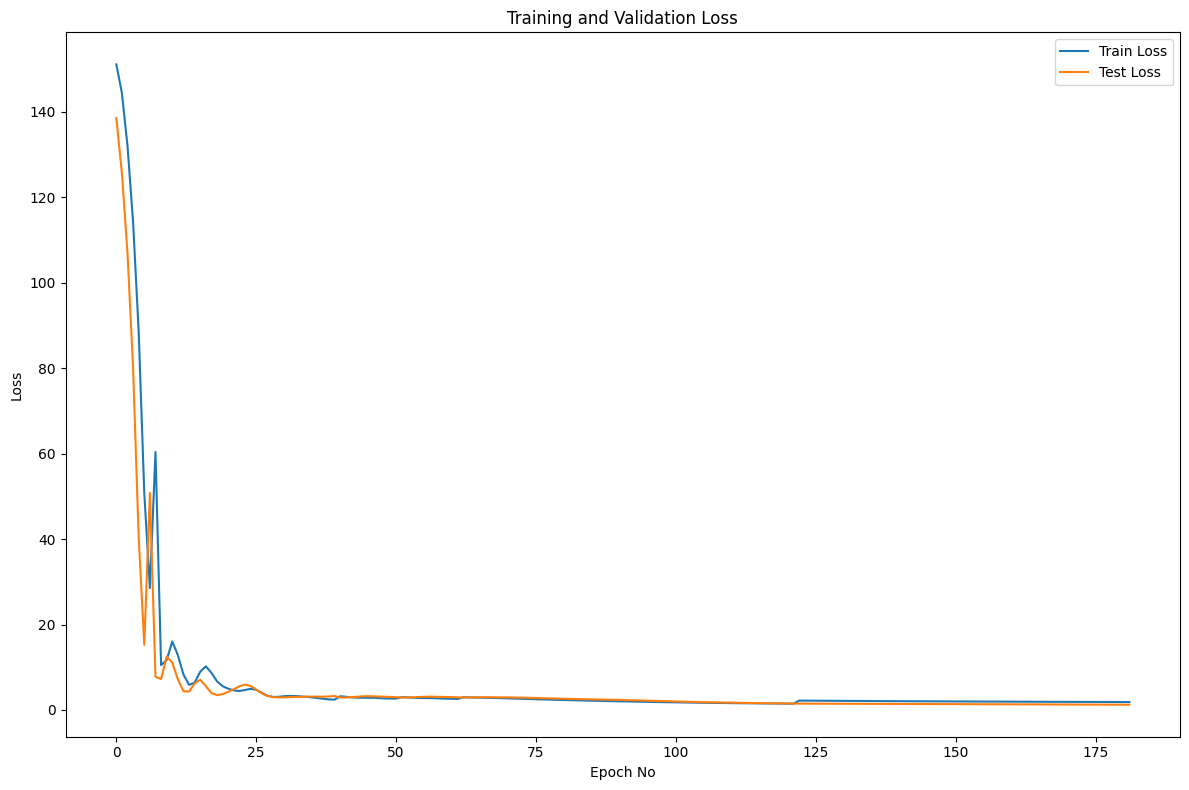

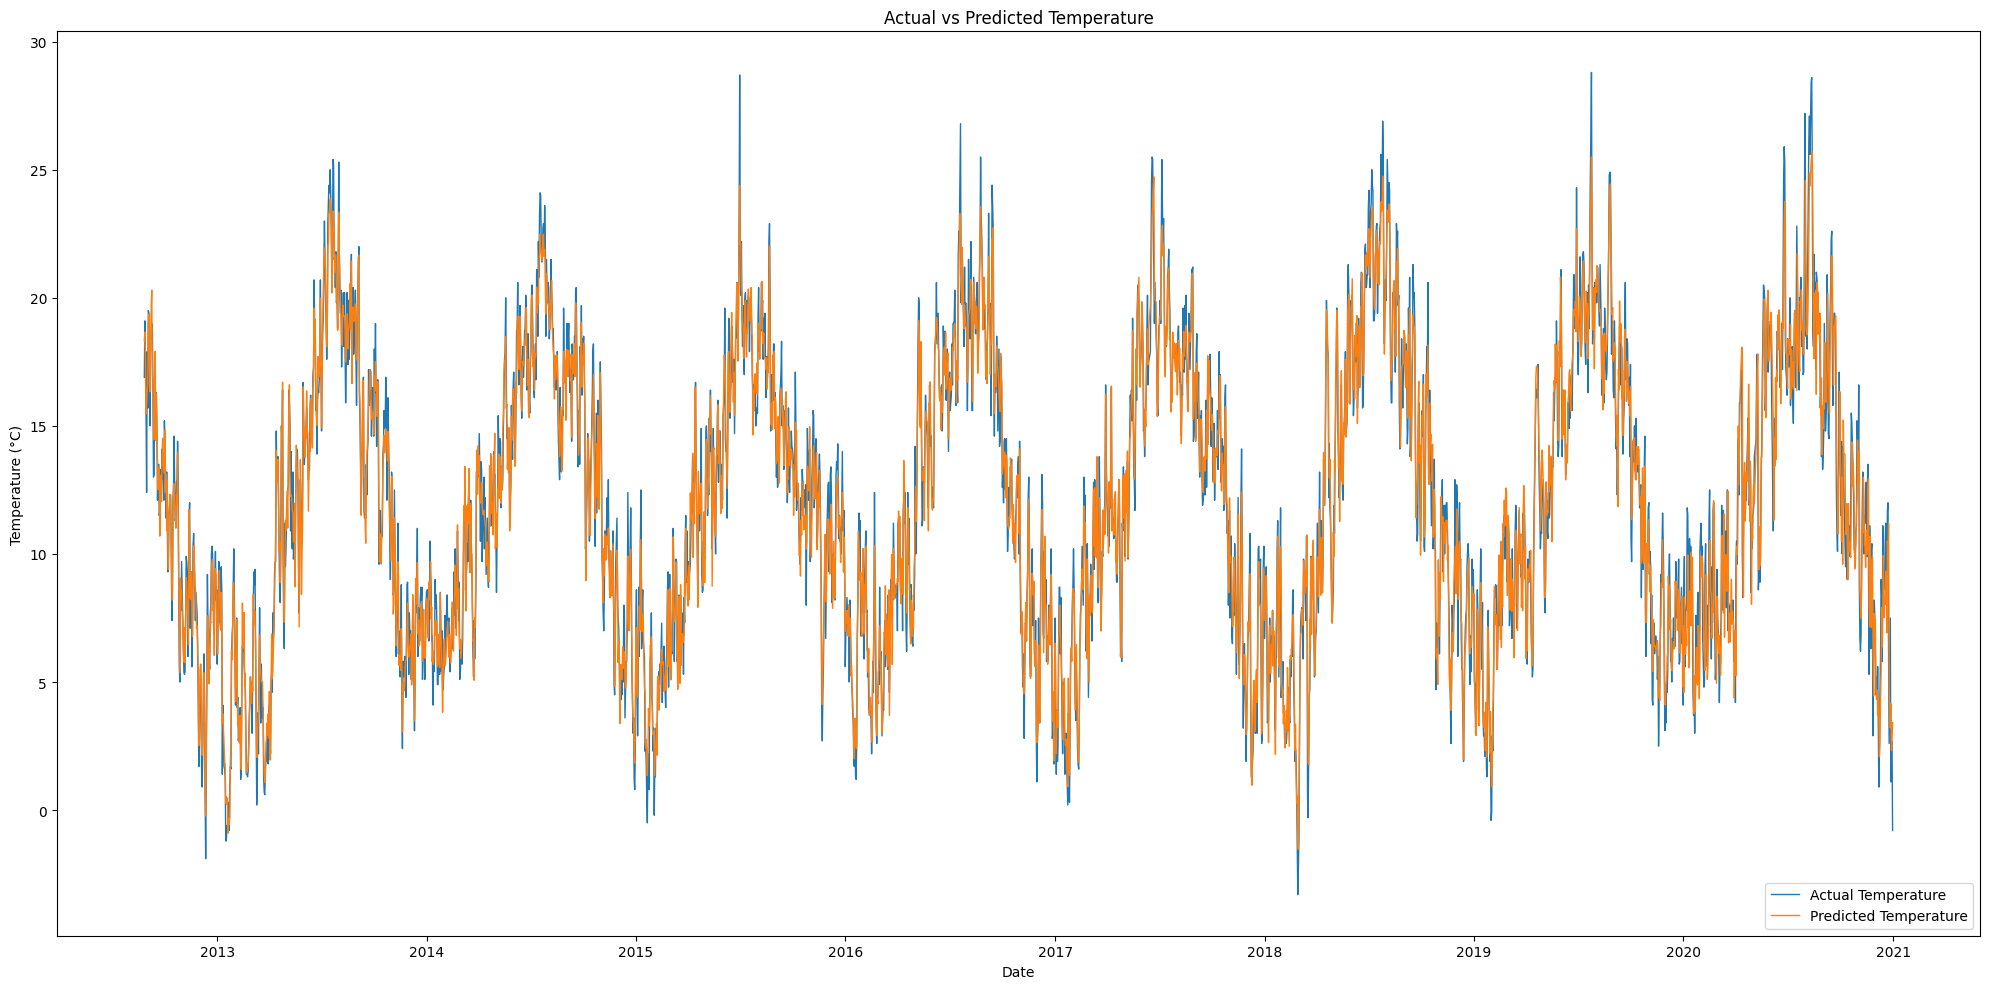

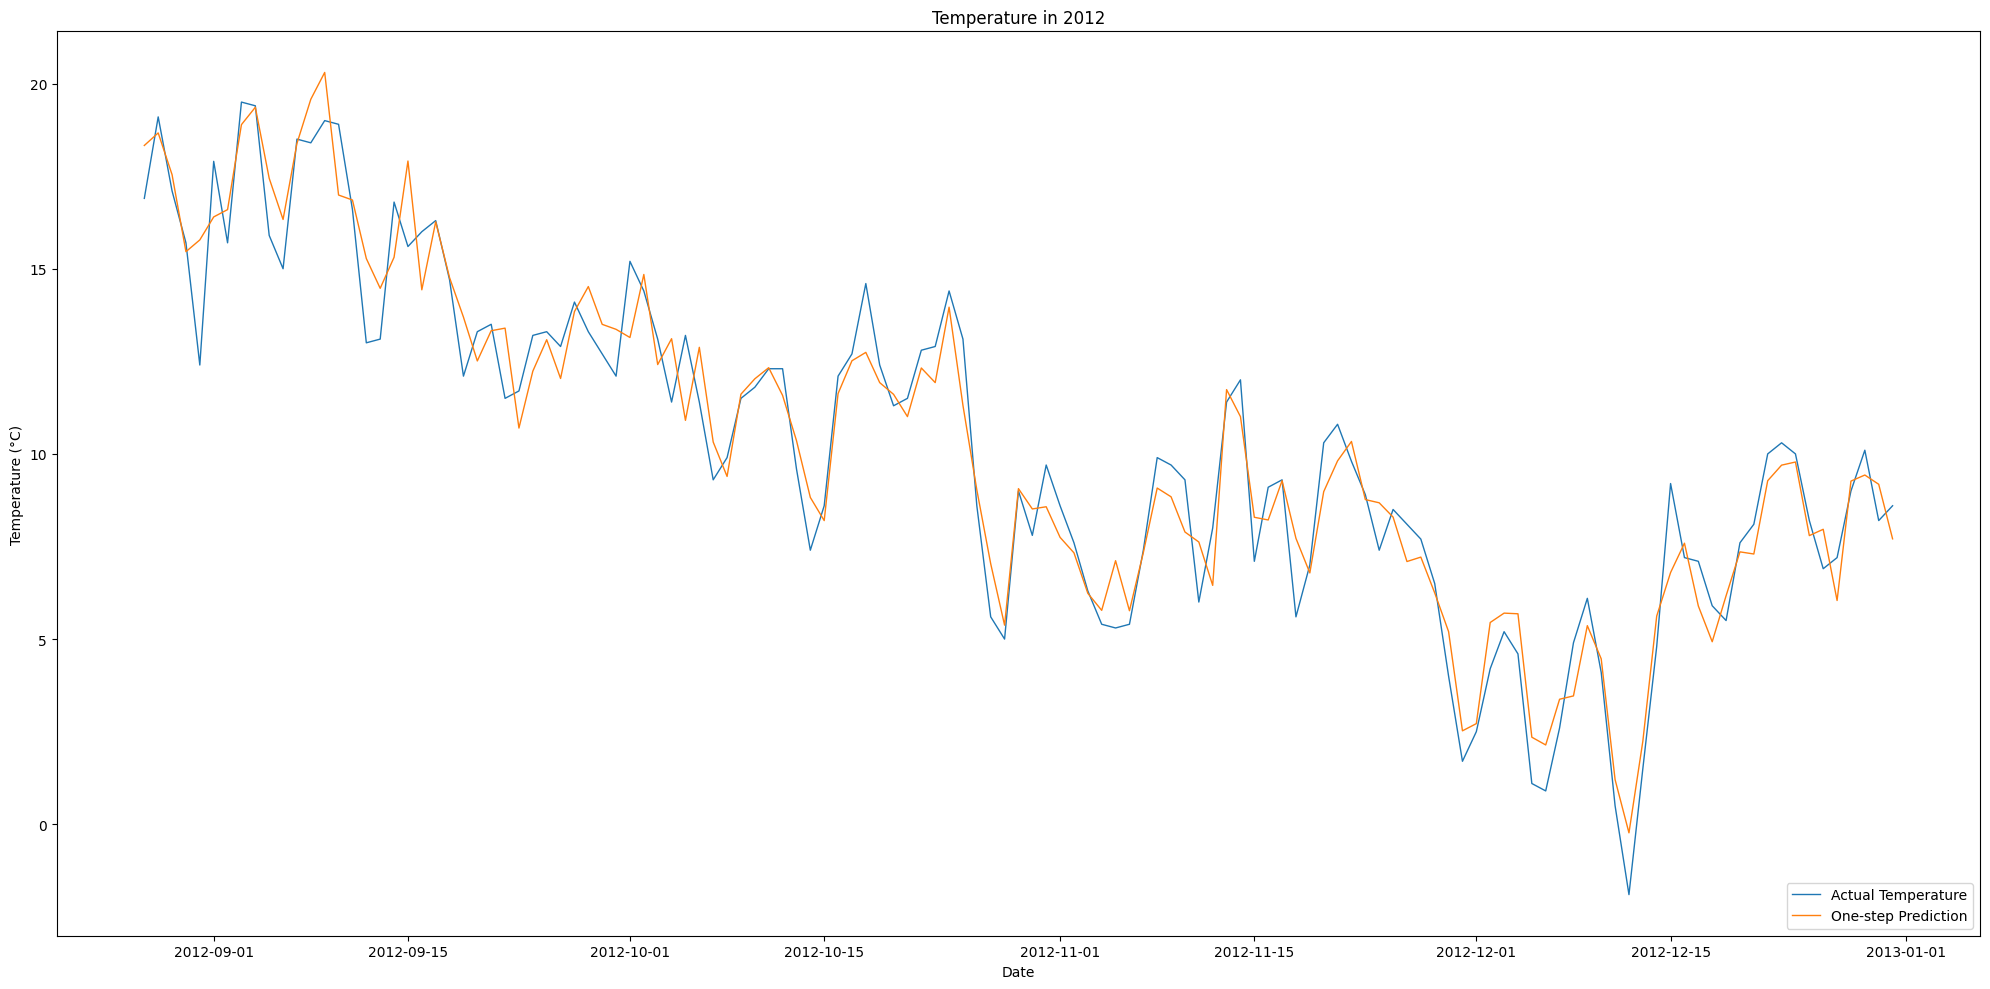

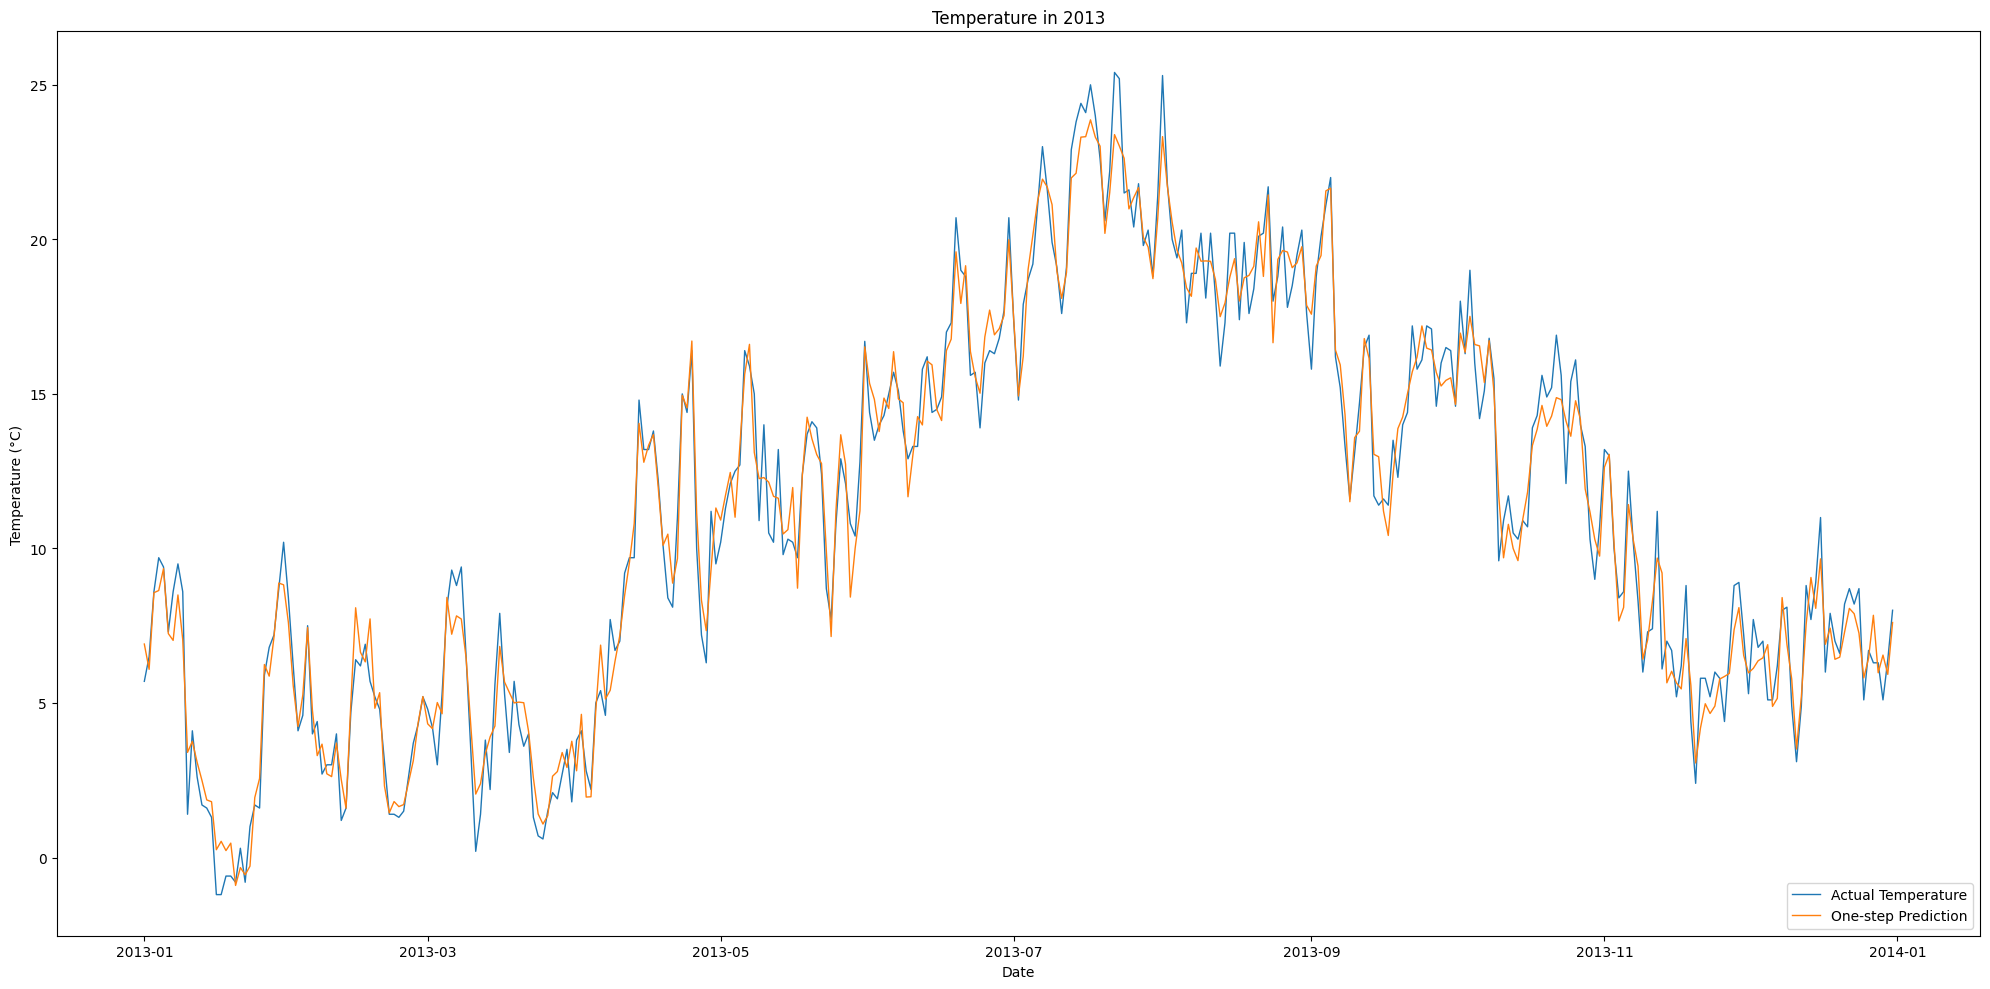

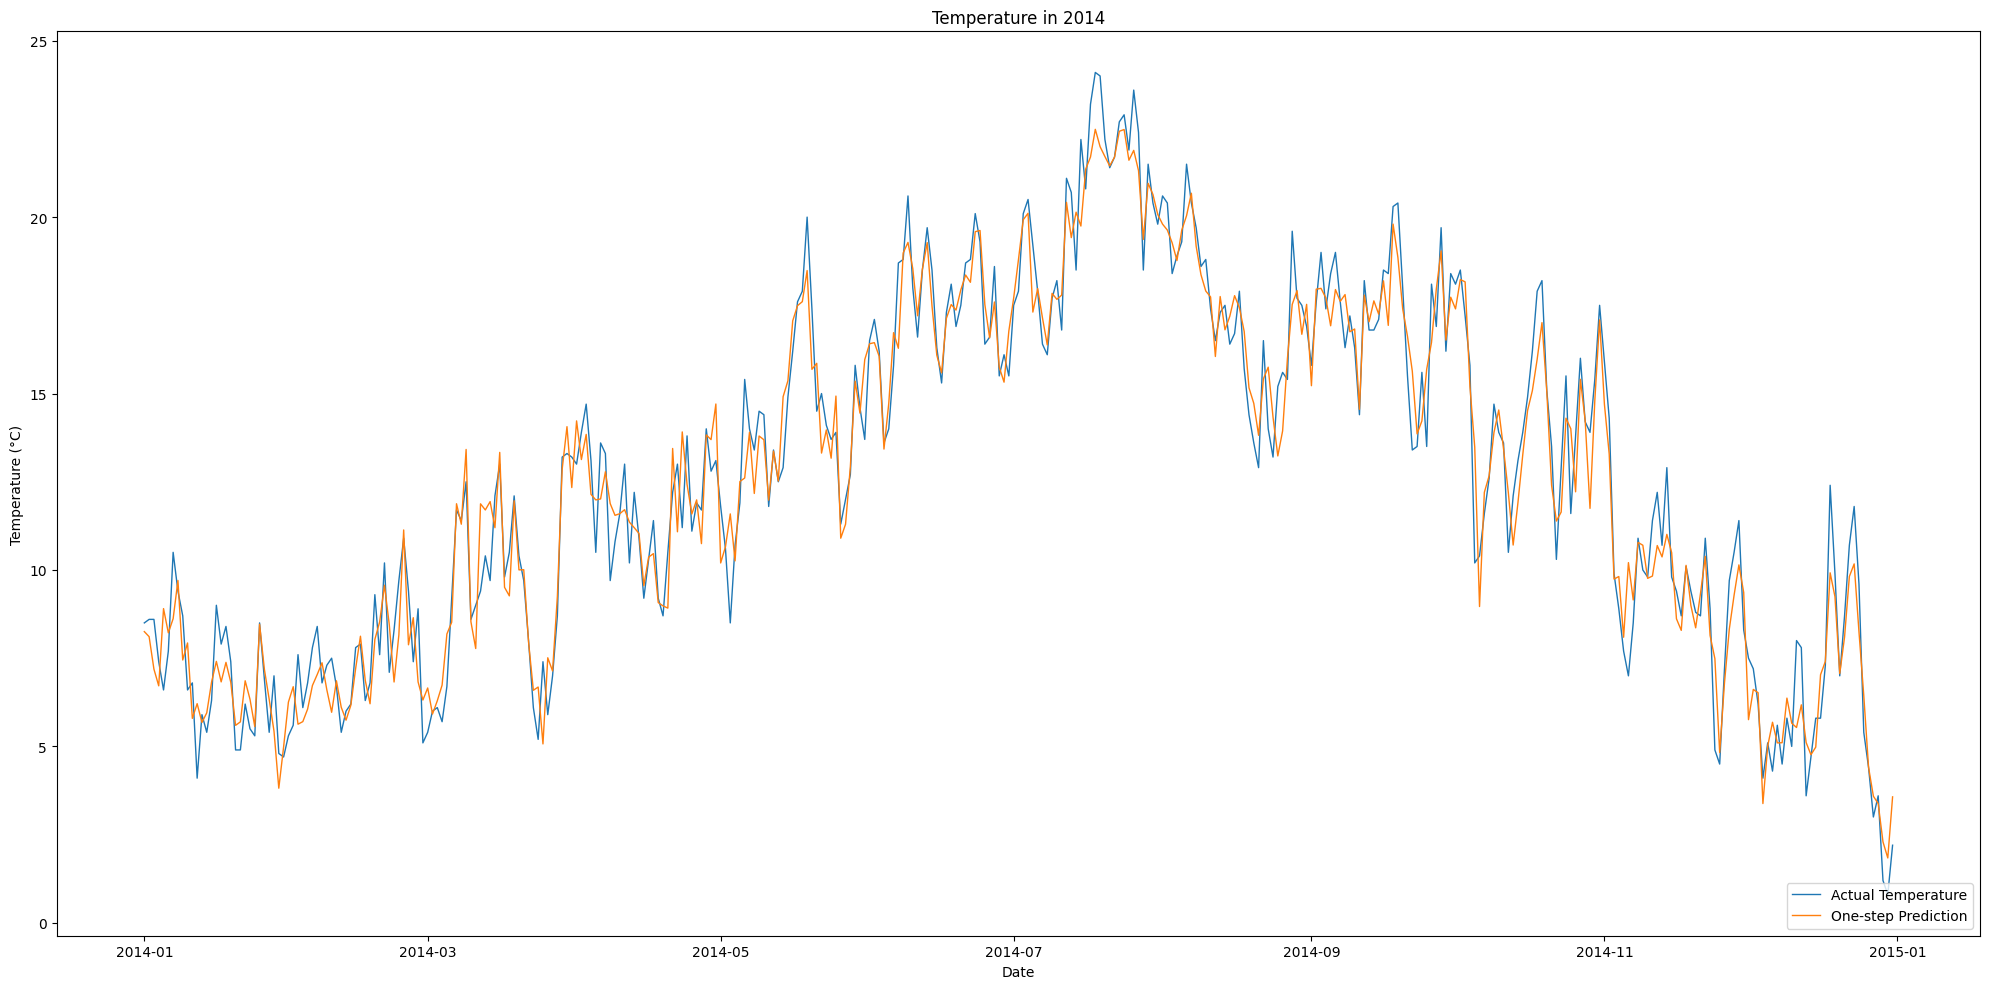

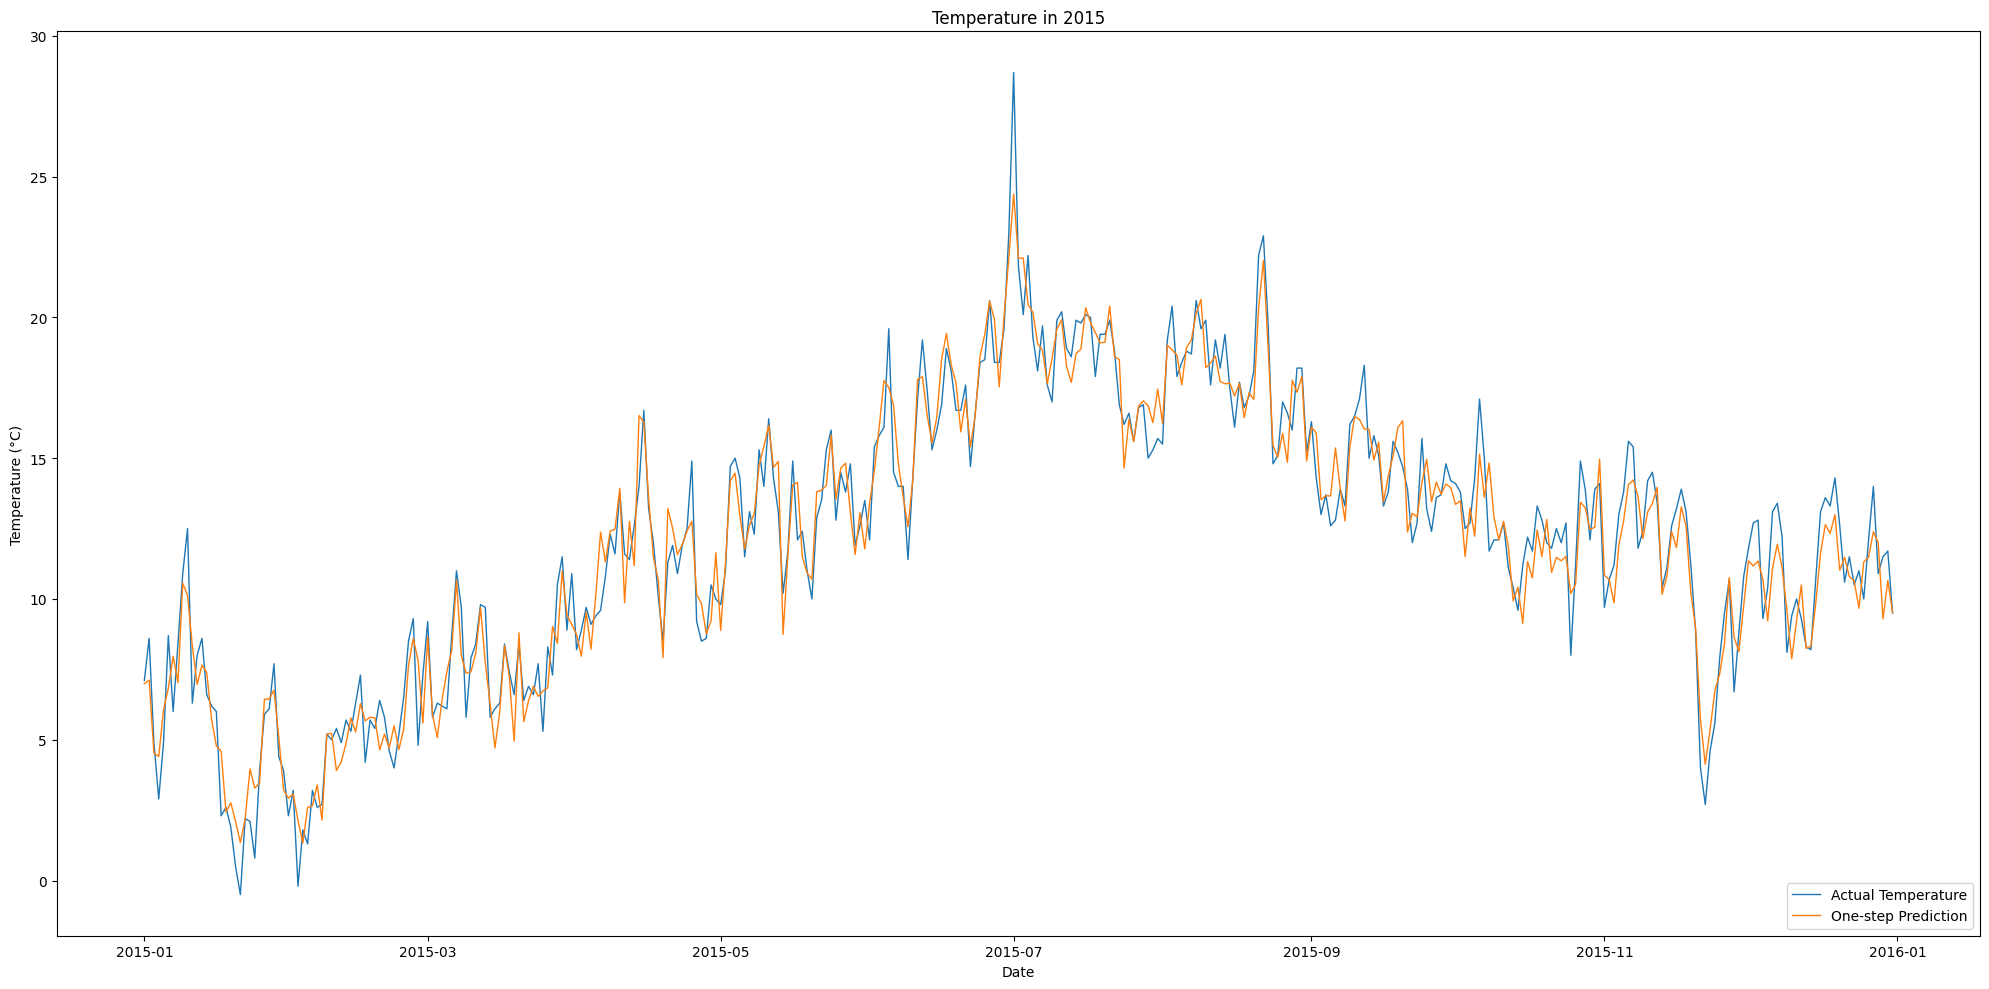

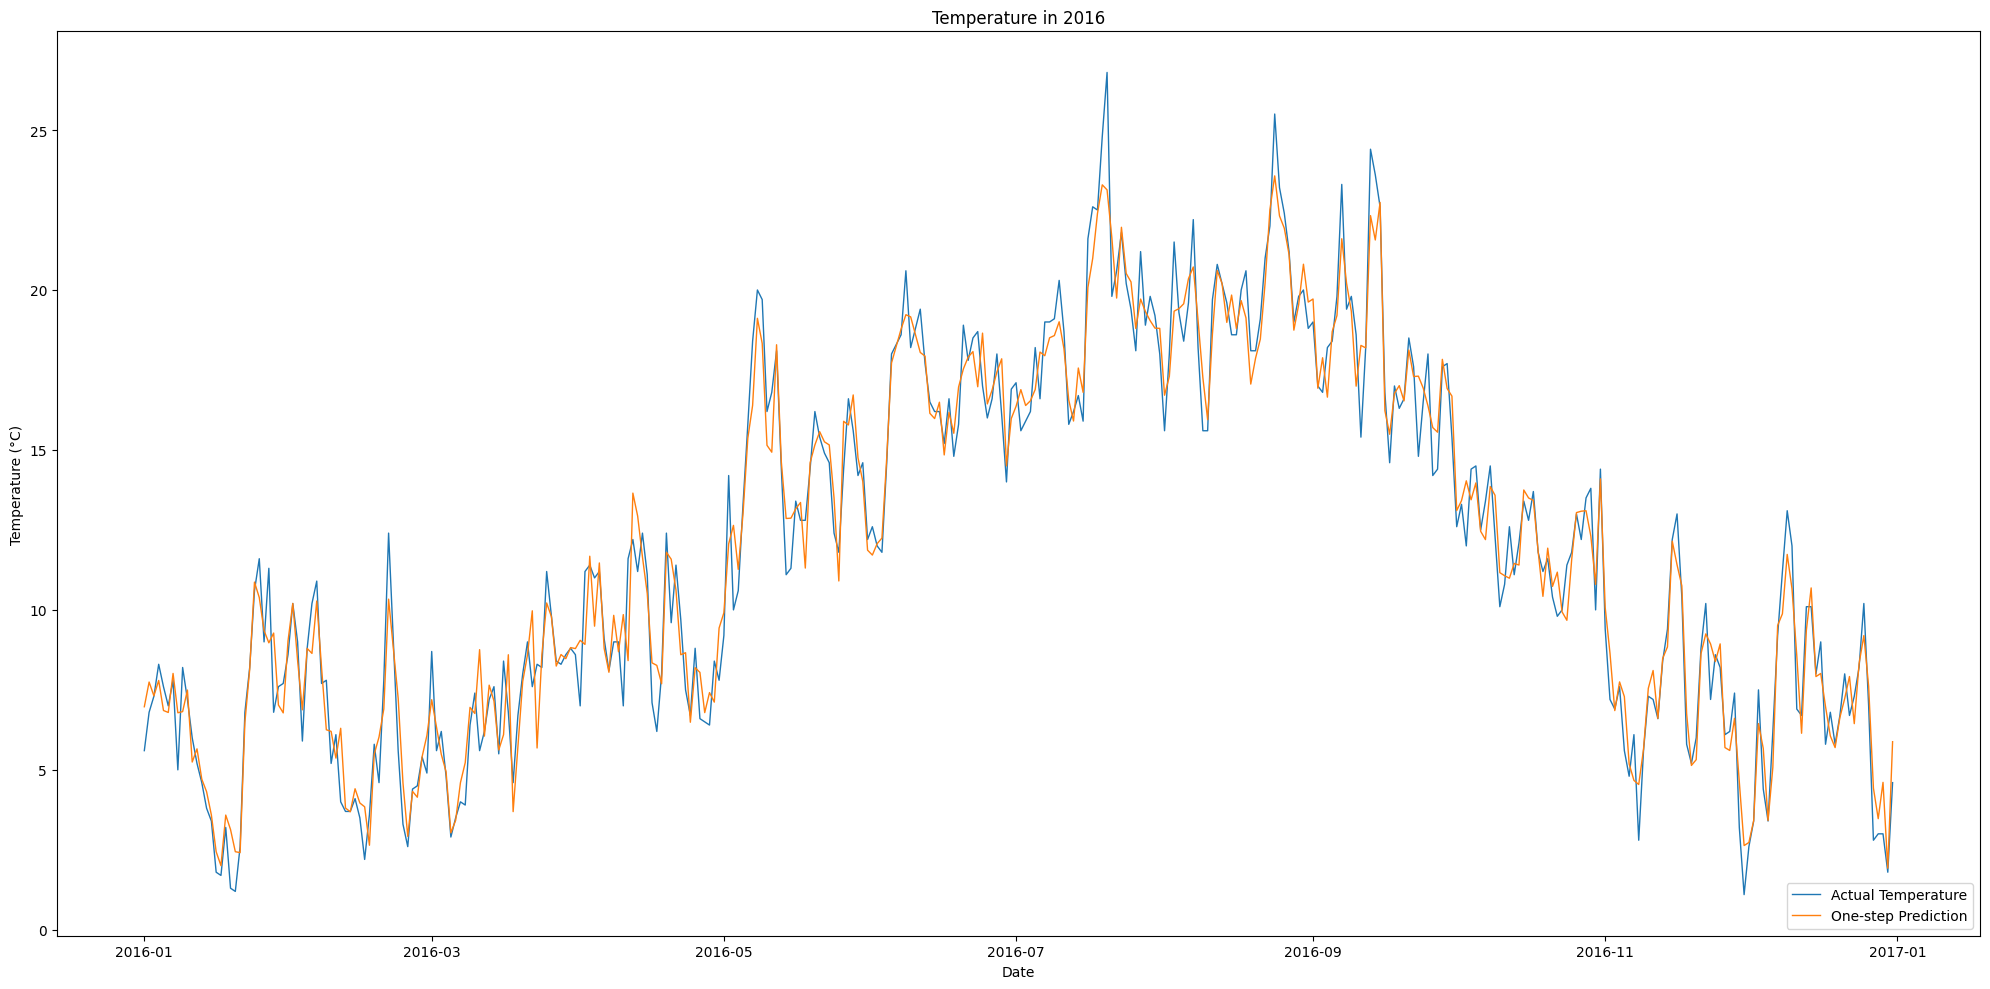

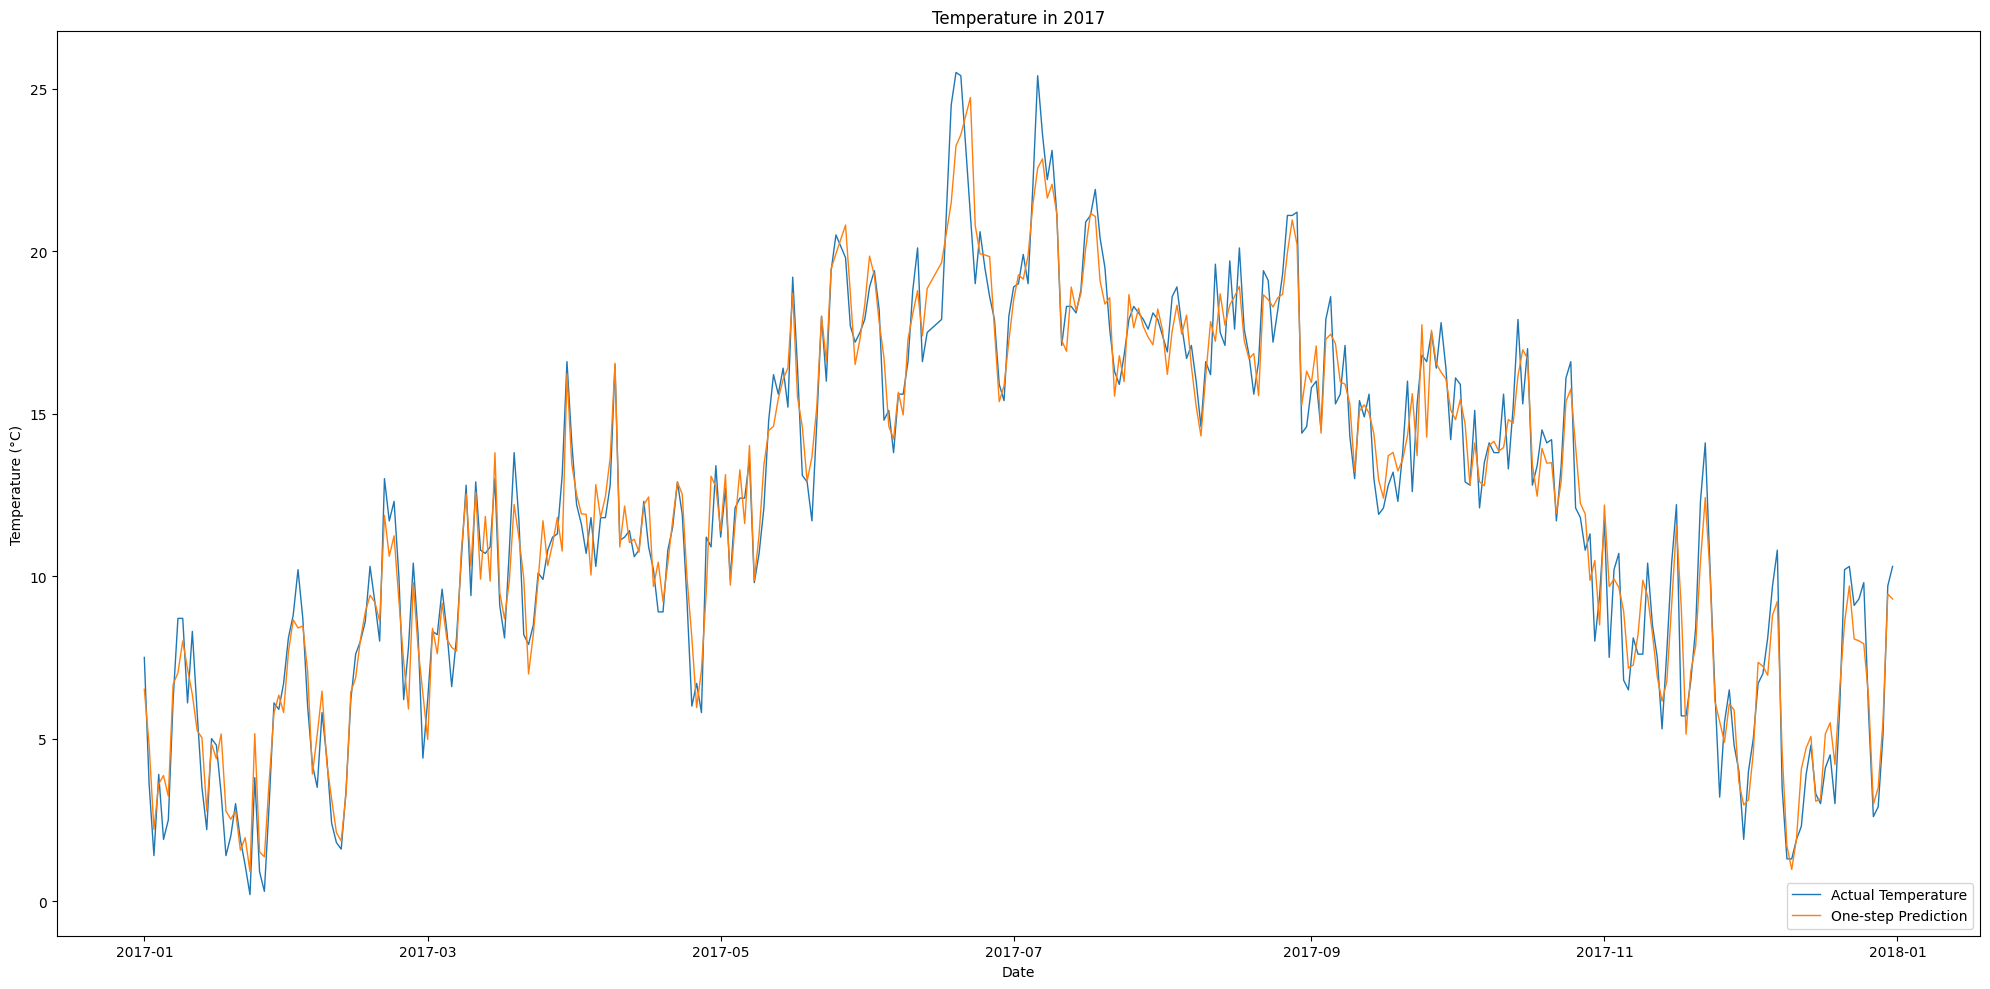

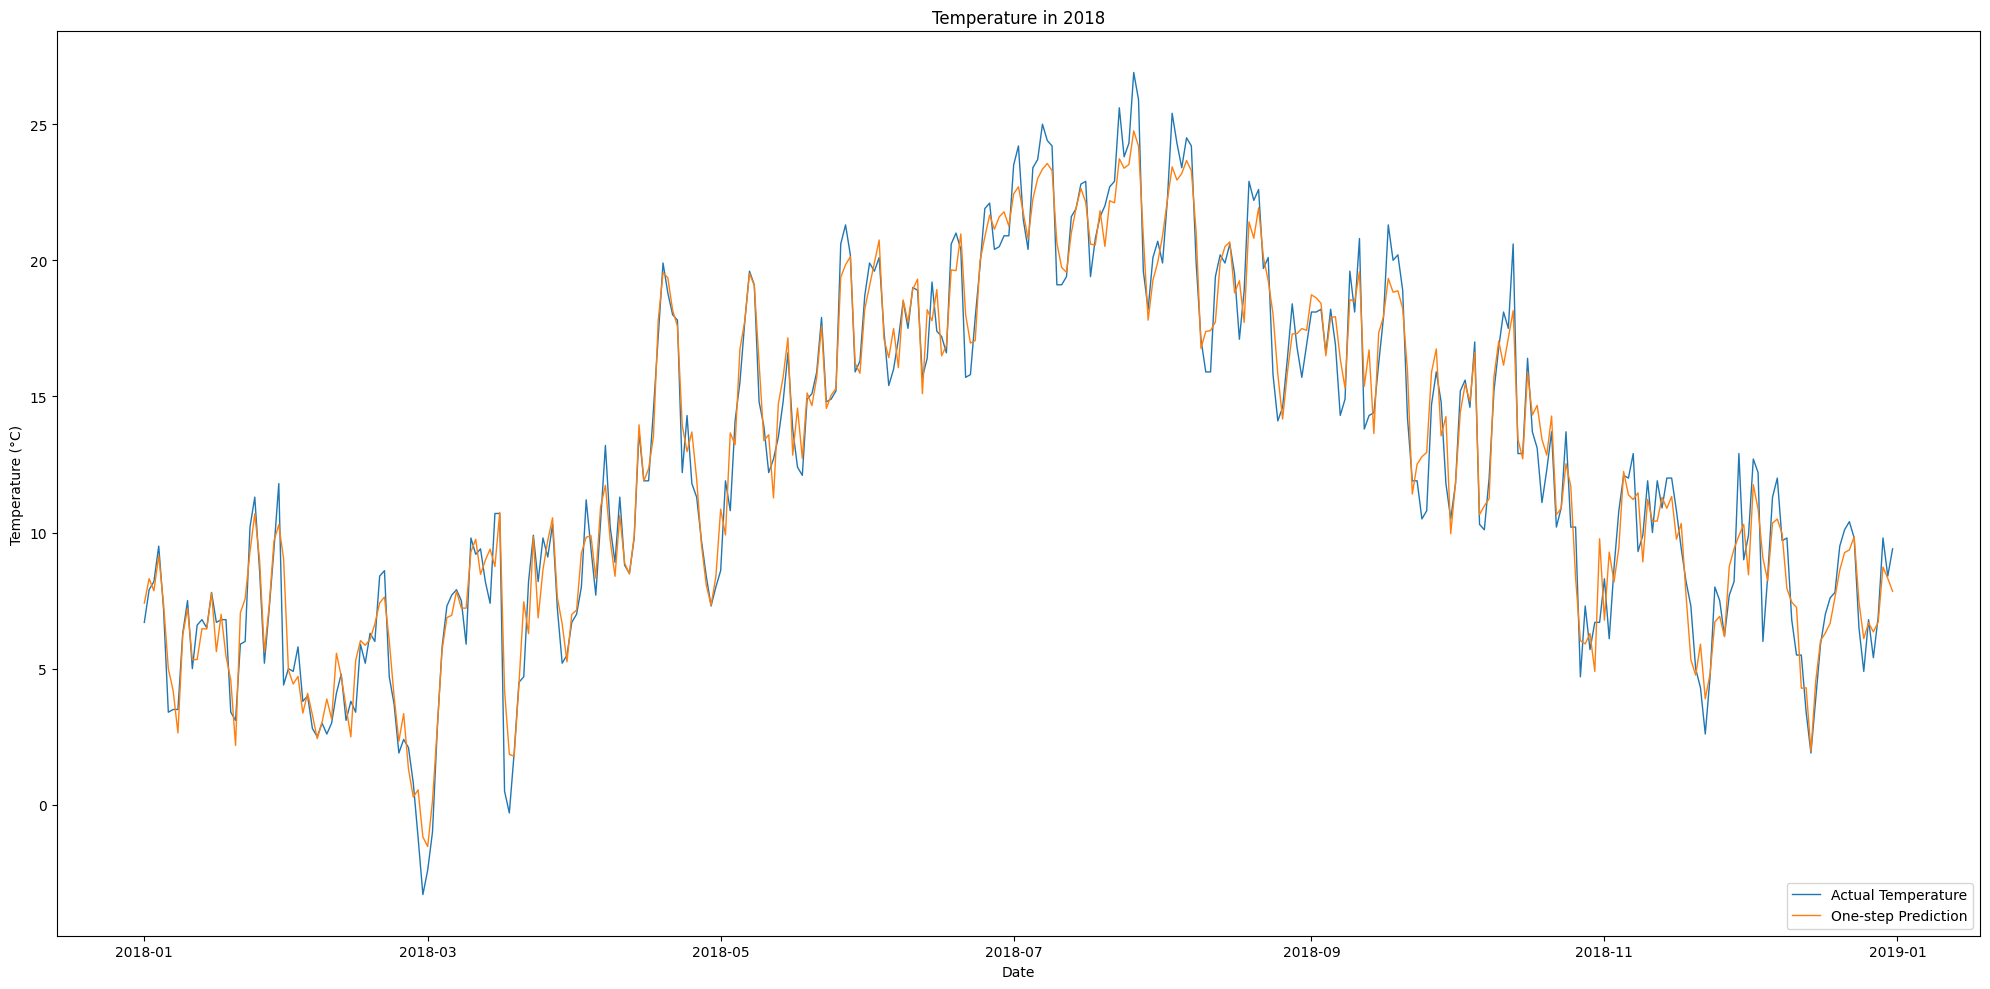

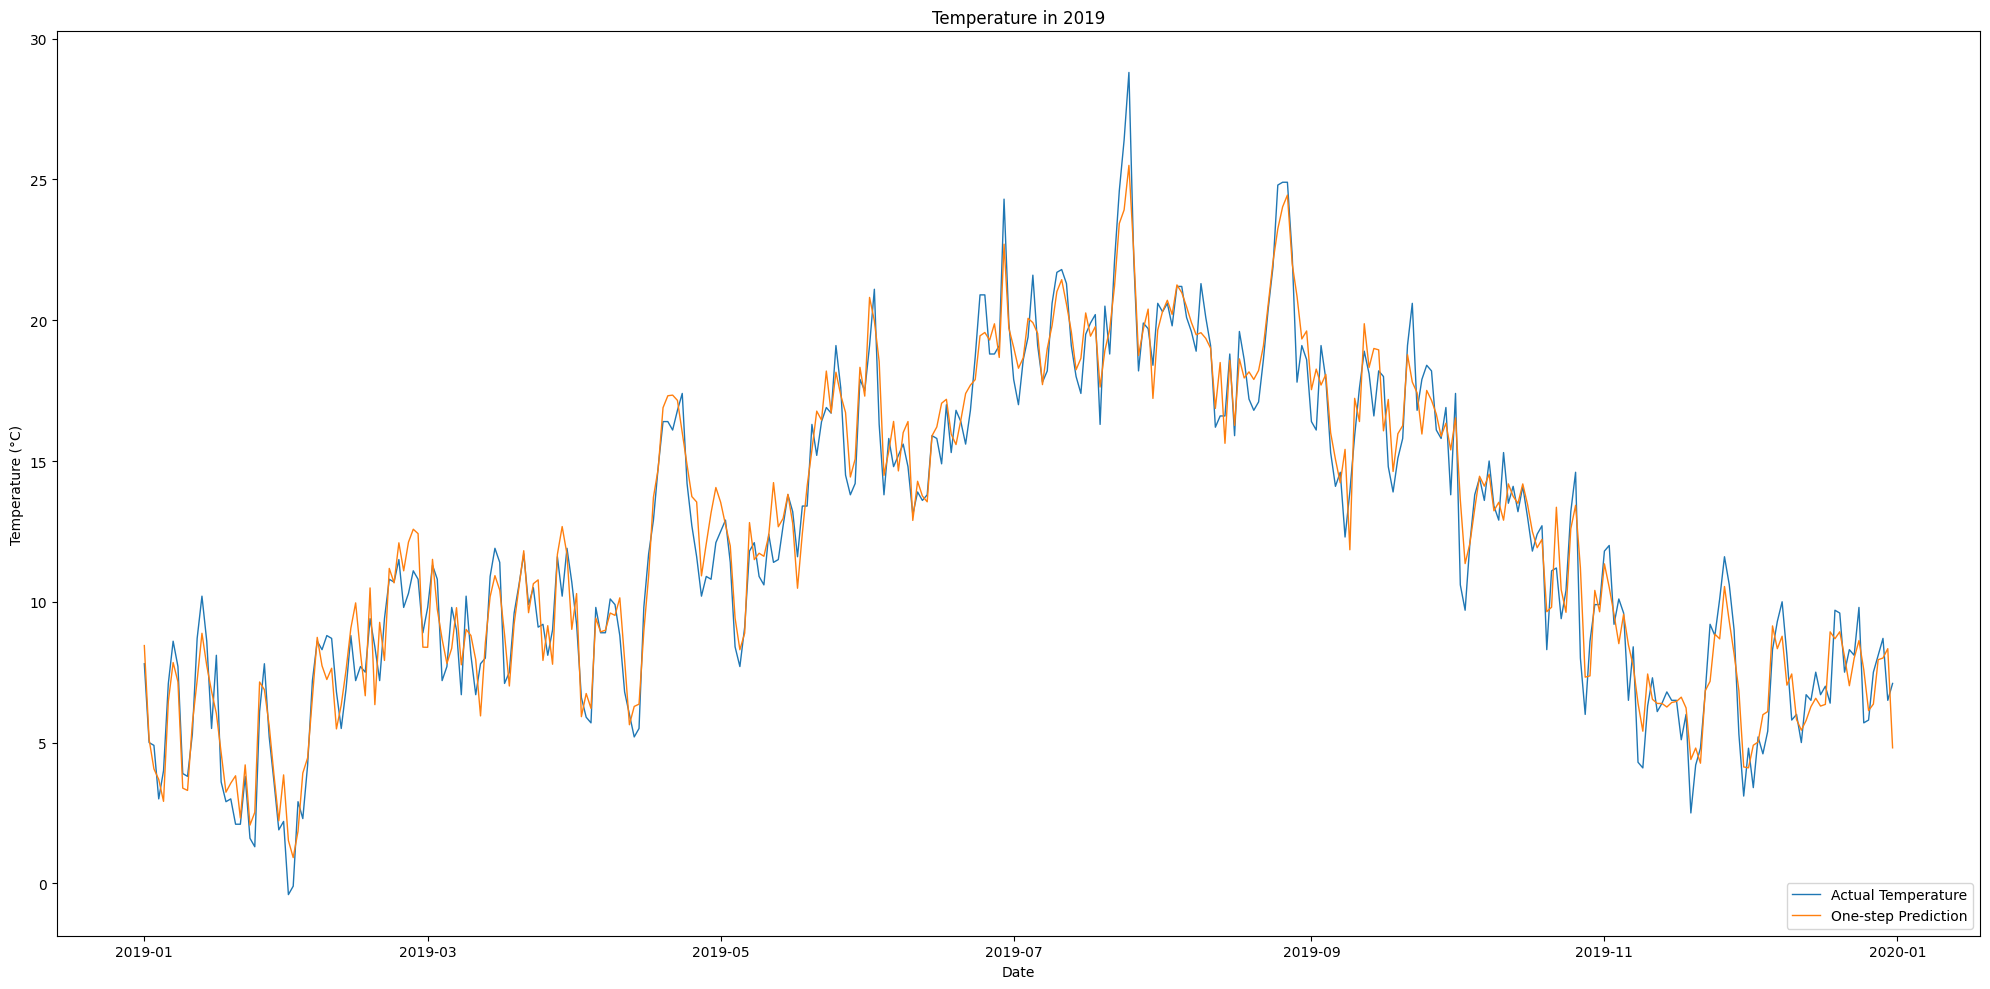

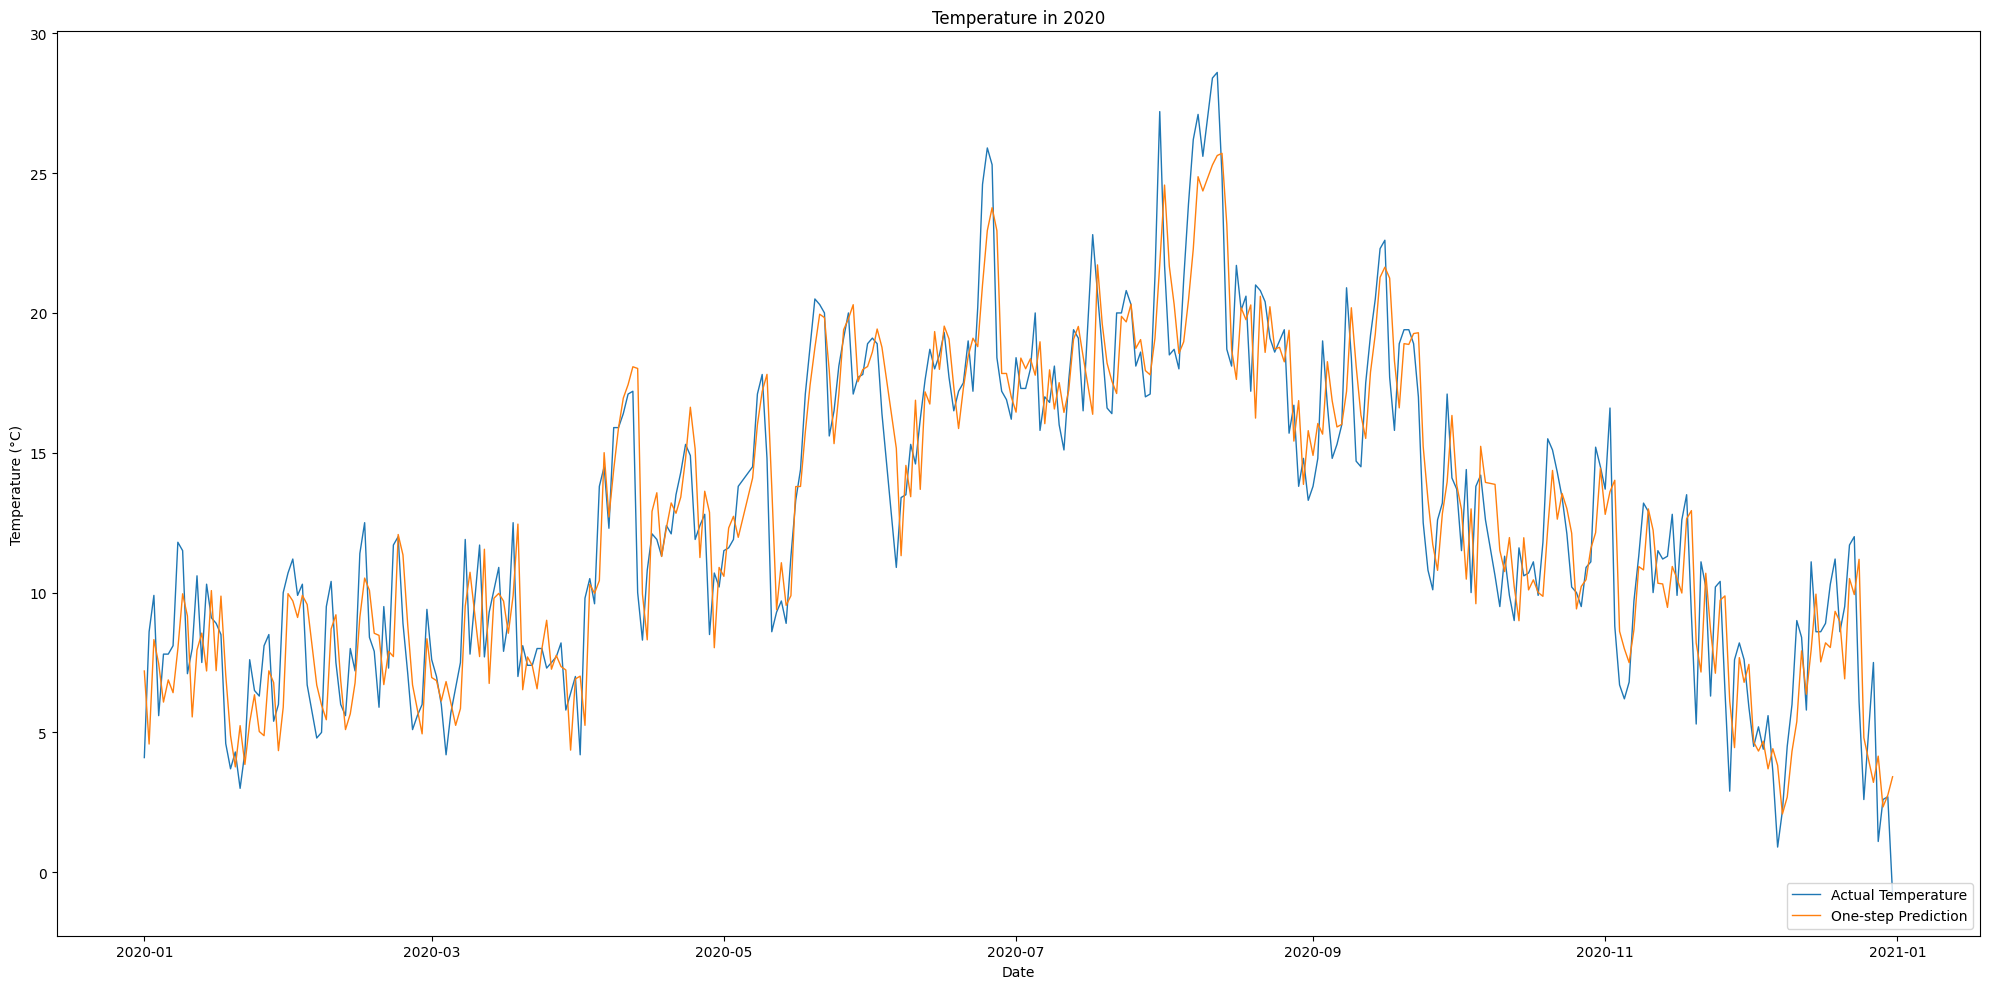

[DISPLAY] Mean square error is: 1.549


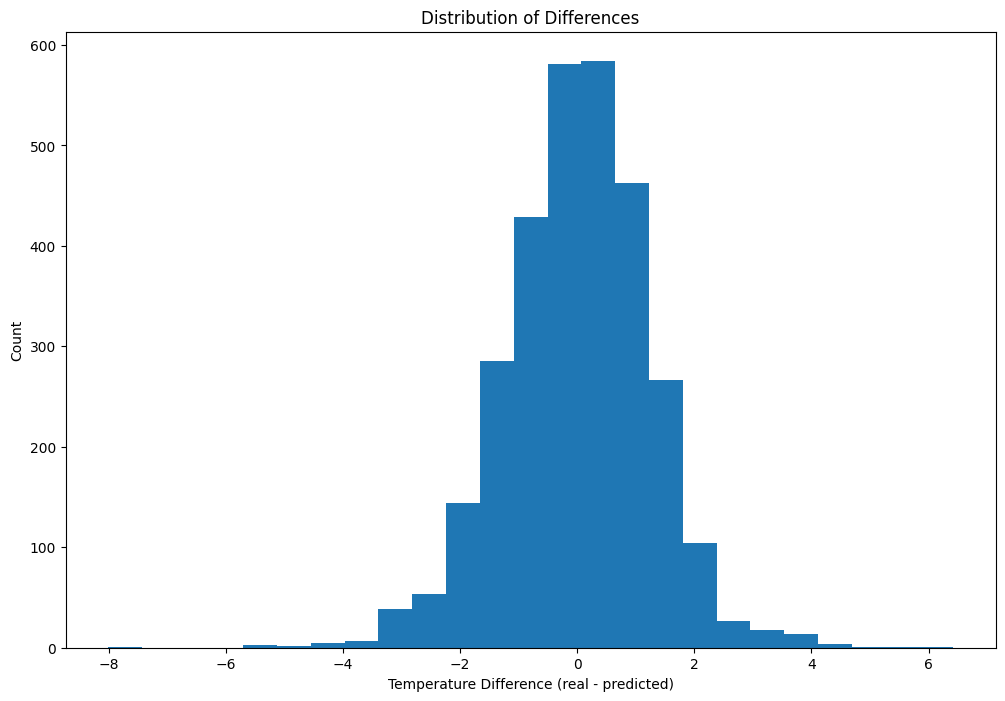

[DISPLAY] Completed in 101.62 seconds
[MAIN] All operations completed
[MAIN] Total execution time: 101.63 seconds

Final Model Performance Metrics:
MAE: 0.9576
MSE: 1.5490
RMSE: 1.2446


In [9]:
main_start_time = time.time()

# Create thread objects
preprocessor = Preprocessing(FILE_PATH)
trainer = Training(pretrained_model=PRETRAINED_MODEL)
inference = Inference()
analyzer = Analysis()
displayer = Display(
    show_loss_plot=True,
    show_main_plot=True,
    show_yearly_plot=True,
    show_error_hist=True
)

# Start all threads
preprocessor.start()
trainer.start()
inference.start()
analyzer.start()
displayer.start()

# Wait for all threads to complete
preprocessor.join()
trainer.join()
inference.join()
analyzer.join()
displayer.join()

main_end_time = time.time()
print("[MAIN] All operations completed")
print(f"[MAIN] Total execution time: {main_end_time - main_start_time:.2f} seconds")

# Print final metrics
print("\nFinal Model Performance Metrics:")
for metric, value in analysis_results['metrics'].items():
    print(f"{metric}: {value:.4f}")